# **Similarity of European Central Bank communications and its impact on financial markets: and extension**

The present notebook implements the code for the paper `Similarity of European Central Bank communications and its impact on financial markets: and extension`


In [1]:
import requests


from bs4 import BeautifulSoup
import pandas as pd



import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from os.path import exists

import numpy as np
import re

from typing import Optional, Callable
from collections import defaultdict


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.lm.preprocessing import everygrams
from string import punctuation
from unidecode import unidecode_expect_ascii

from datetime import timedelta
from datetime import datetime

import statsmodels.api as sm

from statsmodels.tsa.filters.hp_filter import hpfilter

Define plots default size and style:

In [2]:
sns.set(rc={'figure.figsize':(9,3)})
sns.set_style("white")

Define helper functions

In [3]:
def make_sentiment_dict(pos_words:list[str], neg_words:list[str]) -> dict[str, float]:
    sent_dict = defaultdict(lambda: 0)
    sent_dict.update({w.lower(): 1 for w in POS_WORDS})
    sent_dict.update({w.lower():-1 for w in NEG_WORDS})

    return sent_dict


def preprocess_text(s: str, stemmer: Optional[Callable]=None) -> list[str]:
    '''
    Prepare a text string for sentiment analysis

    Parameters
    ----------
    s: str,
        The string to be preprocessed

    stemmer: callable, Optional
        A stemming function to be applied to each token in the string. Should
        take a string and return a string.

    Returns
    ----------
    tokens: list of str,
        A list of tokens, lowercased and stemmed.
    '''

    if not stemmer:
        stemmer = lambda x: x

    s = s.lower()
    tokens = word_tokenize(s)
    stemmed_tokens = [stemmer(w) for w in tokens]

    return stemmed_tokens

def classify_sentences(corpus: list[str],
                       pos_words: list[str],
                       neg_words: list[str],
                       stemmer: Optional[Callable]=None,
                       average_method:str='all') -> list[float]:
    """
    Classify the sentiment of each text in a corpus based on a fixed dictionary.

    Parameters
    -----------
    corpus: list of strings
        A "corpus" of texts. Each text will be converted to a single number,
        representing the sentiment of the text.

    pos_words: list of str
        A list of words to be considered as positive in the sentiment
        analysis

    neg_words: list of str
        A list of words to be considered as negative in the sentiment
        analysis.

    stemmer: callable, optional
        A stemming function to be applied to each token in the string. Should
        take a string and return a string.

    average_method: str, default = 'all'
        The method used to normalize the sentiment scores between 0 and 1.
            "all" will divide the sentiment by the total number of tokens in the text
            "has_sentiment" will divide by the number of non-zero sentiment tokens

    Returns
    ----------
    scores: list of floats
        A list of sentiment scores

    """
    if average_method not in ['all', 'has_sentiment']:
        raise NotImplementedError()

    sent_dict = make_sentiment_dict(pos_words, neg_words)

    scores = []
    for text in corpus:
        tokens = preprocess_text(text, stemmer)
        word_scores = list([sent_dict[token] for token in tokens])
        n = len(tokens) if average_method == 'all' else sum([abs(x) for x in word_scores])
        score = sum(word_scores) / n
        scores.append(score)
    return scores

# 1. Scrapping the conferences 

## 1.1 Scrapping the links 

In [4]:
if exists("ecb_scraped.csv"):
    df = pd.read_csv("ecb_scraped.csv")
else:
    url = "https://www.ecb.europa.eu/press/pressconf/{}/html/index_include.en.html"
    urls = []
    
    df =[]
    
    for year in range(1990, 2025):
        soup = BeautifulSoup(requests.get(url.format(year)).content, "html.parser")
        for a in soup.select(".title a")[::-1]:
          date = a.find_previous(class_="date").text
          name = a.text
          link = "https://www.ecb.europa.eu" + a["href"]
          urls.append({'date': date, 'Name': name, 'Link': link})
    
    df = pd.DataFrame(urls)
    
    #Keep only monetary policy statements
    df = df[df['Name'].str.contains('Monetary policy statement|Introductory statement')==True]
    df = df[df['Name'].str.contains('Introductory statement on the winning design chosen in the international urban planning and architectural design competition')==False]

## 1.2 Scrapping the conference texts 

In [5]:
if exists("ecb_scraped.csv"):
    print("text already scrapped")
else:

    alocation = []
    apresident = []
    avice_president = []
    atext = []
    
    for pressconf in df['Link']:
      url = pressconf
      data = requests.get(url)
    
      page = requests.get(url).content
      soup = BeautifulSoup(page, parser='lxml-parser', features='html')
      textbox = soup.find('main')
    
      name = soup.find('div', class_='title').get_text().strip()
    
      try:
          location_text = textbox.find(class_='ecb-publicationDate').get_text()
      except:
          location_text = "null"
          pass
    
      title_text = textbox.find('h2', class_='ecb-pressContentSubtitle').get_text()
    
      header = soup.find('head')
      header_text = header.find('title').get_text()
    
    
      title_text = title_text.replace('-', ' ')
      title_text = title_text.replace('European Central Bank', 'ECB')
      title_text = title_text.replace(' and ', ', and ')
    
      ps = textbox.find_all('p')
    
      items = title_text.split(',')
    
      president = None
      vice_president = None
      location = None
      date = None
    
      # Check for president
      Pres = [x for x in items if 'President' in x and 'ECB' in x and 'Vice' not in x]
      if len(Pres) == 1:
          p_idx = items.index(Pres[0]) - 1
          president = items[p_idx].strip()
    
      # Check for Vice-President
      VP = [x for x in items if 'Vice President' in x and 'ECB' in x]
      if len(VP) == 1:
          vp_idx = items.index(VP[0]) - 1
          vice_president = items[vp_idx]
    
      if location_text != 'null':
        #location
        location = location_text.split(', ')[0]
        location = location.strip()
        #date
        date = location_text.split(', ')[1]
        date = date.strip()
        #remove from start of text
    
      if location_text == 'null':
          if len(items) == 6:
              location = items[4]
              date = items[5]
          # Case 2: There was no comma separating the VP and the location.
          elif len(VP) > 0:
              candidate = VP[0].replace('Vice President of the ECB', '').strip()
              if candidate != '':
                  location = candidate
                  date = items[3]
    
      text='\n'.join([x.get_text() for x in ps])
      text = text.replace("\n", " ")
      text = text.replace("\t", " ")
      text = text.split('***', 1)[0]
      text = text.split('* * *', 1)[0]
      text = text.split('Transcript of the questions asked', 1)[0]
      text = text.split('Question:', 1)[0]
      text = text.split('QUESTION:', 1)[0]
      text = text.split('My first question would be', 1)[0]
      text = text.split('Question (translation):', 1)[0]
      text = text.split('Q:', 1)[0]
      text = text.replace("Click here for the transcript of questions and answers. ", "")
      text = text.replace("With the transcript of the questions and answers ", "")
      text = text.replace("With a transcript of the questions and answers ", "")
      text = text.replace("Reproduction is permitted provided that the source is acknowledged.", "")
      text = text.replace("Disclaimer Please note that related topic tags are currently available for selected content only.", "")
    
      if location_text != 'null':
        if text.startswith(location) == True:
          text = text.split(date[-4:], 1)[1]
    
      alocation.append(location)
      apresident.append(president)
      avice_president.append(vice_president)
      atext.append(text)
    
    
    
    df['location'] = alocation
    df['president'] = apresident
    df['vice_president'] = avice_president
    df['text'] = atext

text already scrapped


After a manual review, I discovered that there are 4 meeting dates that were omitted by the ECB webpage as they did not have press conference. I omit them from the analysis as the original paper only considers conferences. For more information regarding those meetings, check:
*  16 March 2000 https://www.ecb.europa.eu/press/pr/date/2000/html/pr000316.en.html
*  31 August 2000 https://www.ecb.europa.eu/press/pr/date/2000/html/pr000831.en.html
*  17 September 2001 https://www.ecb.europa.eu/press/pr/date/2001/html/pr010917.en.html
*  08 October 2008 https://www.ecb.europa.eu/press/pr/date/2008/html/pr081008.en.html

Additionally, the manual review allowed us to identify that our file contained 2 ECB conferences that were not related with monetary policy meetings:
* 13 October 2003 https://www.ecb.europa.eu/press/pressconf/2003/html/is031013.en.html
* 20 January 2005 https://www.ecb.europa.eu/press/pressconf/2005/html/is050120.en.html

I proceed to remove those rows and to drop data before 1999

In [6]:
df = df.drop(index=[62, 77])
df = df.tail(-7)

# 2. Import additional data 

## 2.1 Importing the MRO rates 

First I download and then import the MRO rates from the ECB website: https://data.ecb.europa.eu/main-figures/ecb-interest-rates-and-exchange-rates/key-ecb-interest-rates

In [7]:
colnames=['date', 'time_per', 'MRO']
rate_df = pd.read_csv("MRO_rates.csv", names=colnames)

rate_df = rate_df.tail(-1)

rate_df

,date,time_per,MRO
1.0,1/1/1999,1-Jan-99,3
2.0,1/2/1999,2-Jan-99,3
3.0,1/3/1999,3-Jan-99,3
4.0,1/4/1999,4-Jan-99,3
5.0,1/5/1999,5-Jan-99,3
...,...,...,...
9173.0,2/11/2024,11-Feb-24,4.5
9174.0,2/12/2024,12-Feb-24,4.5
9175.0,2/13/2024,13-Feb-24,4.5
9176.0,2/14/2024,14-Feb-24,4.5


I convert the date format and set the date as index, and extract the year, as it will be required for Table 1

In [8]:
rate_df['date'] = pd.to_datetime(rate_df["date"])
rate_df.set_index("date", inplace = True)

mro = rate_df["MRO"].sort_index().copy().to_frame()

mro['year'] = mro.index.year

In [9]:
mro = mro.head(-16)

mro

,MRO,year
date,,
1999-01-01,3,1999
1999-01-02,3,1999
1999-01-03,3,1999
1999-01-04,3,1999
1999-01-05,3,1999
...,...,...
2024-01-26,4.5,2024
2024-01-27,4.5,2024
2024-01-28,4.5,2024


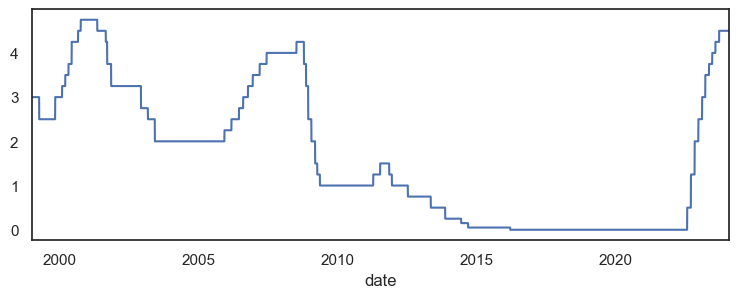

In [10]:
mro["MRO"].astype(float).plot();

## 2.2 Importing DJEUROSTOXX50 

The data for the DJEurostoxx50 index was extracted from Google Finance, using the Google Sheets module. I used Google Finance instead of Yahoo Finance API, because it has the complete period of the analysis, while Yahoo Finance only has data from April 2007

Produced in google sheets with:

`# =GOOGLEFINANCE("SX5E", "price", DATE(1998,1,1), DATE(2025,12,31), "DAILY")`




In [11]:
stock_index = pd.read_csv("DJEurostoxx.csv")
stock_index["Date"] =  pd.to_datetime(stock_index["Date"]).dt.date

stock_index.set_index("Date", inplace = True)

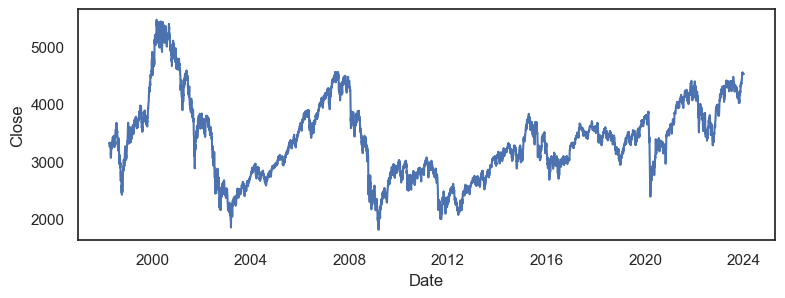

In [12]:
sns.lineplot(data=stock_index["Close"].head(6555));

To calculate the abnormal returns I use:

$$CAR_i = \sum_{t=-5}^{5}AR_{i,t} $$
where:
$$AR_{i,t} = R_{i,t}- \overline{R}_{i,t} $$
and $\overline{R}_{i,t}$ is given by a 201 days moving average around 250 days to 50 days before the announcement:
$$\overline{R}_{i,t} = \frac{1}{201} \sum_{t=-250}^{50} $$


In [13]:
# Moving average
stock_index["returns"] = np.log(stock_index["Close"]).diff()

stock_index["mean_returns"] = stock_index["returns"].rolling(201, min_periods = 100 ).mean().shift(50)

In [14]:
# Abnormal returns
stock_index["abnormal_returns"]= stock_index["returns"] - stock_index["mean_returns"]

# rolling window
stock_index["cum_ab_returns"] = stock_index["abnormal_returns"].rolling(window=11, center = True).sum()

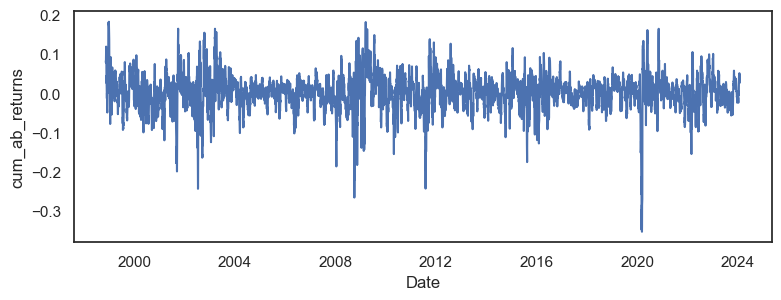

In [15]:
sns.lineplot(data=stock_index["cum_ab_returns"]);

Finally, as the authors want to evaluate the size of the market reaction independently of its direction, I use the absolute value of the Cumulative Abnormal returns

In [16]:
stock_index["AV_cum_ab_returns"] = abs(stock_index["cum_ab_returns"])

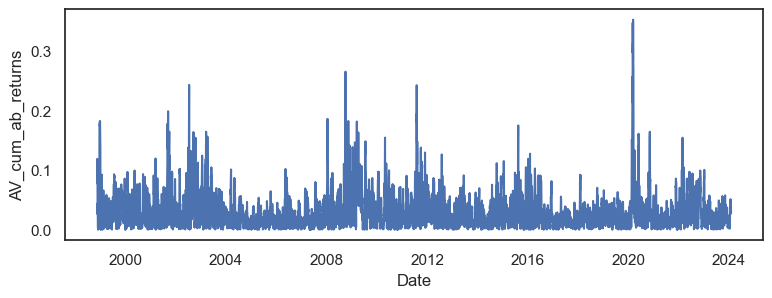

In [17]:
sns.lineplot(data=stock_index["AV_cum_ab_returns"]);

## 2.3 Importing Quarterly real GDP 

I downloaded the quarterly real GDP for the Eurozone from FRED repository. Now I upload the file

Note that the article uses EU19

https://fred.stlouisfed.org/series/CLVMEURSCAB1GQEA19

In [18]:
GDP = pd.read_csv("EU19_real_GDP.csv")
GDP.rename(columns = {"CLVMEURSCAB1GQEA19": "GDP_quart", "DATE": "date"}, inplace = True)
GDP["date"] = pd.to_datetime(GDP["date"])
GDP.set_index("date", inplace = True)

To obtain the output GAP, I use the Hodrick–Prescott filter.

In [19]:
GDP["GDP_quart_ham_cyc"] = hpfilter(np.log(GDP["GDP_quart"]*4), lamb=1600)[0]
GDP["GDP_quart_ham_trend"] = hpfilter(np.log(GDP["GDP_quart"]*4), lamb=1600)[1]

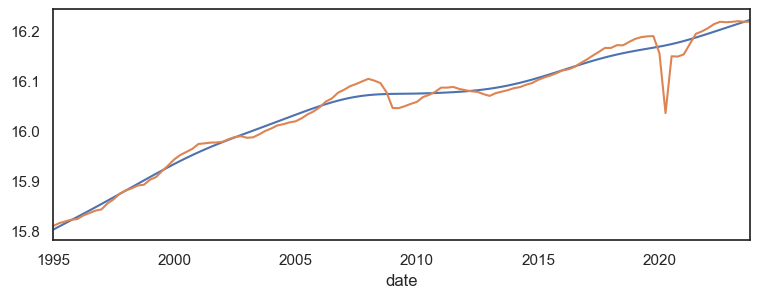

In [20]:
GDP["GDP_quart_ham_trend"].plot()
np.log(GDP["GDP_quart"]*4).plot();

In [21]:
GDP["output_gap_quart"] = GDP["GDP_quart_ham_cyc"]

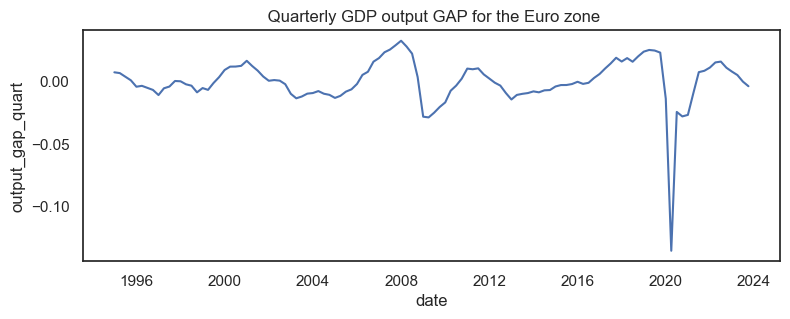

In [22]:
sns.lineplot(data=GDP["output_gap_quart"]).set(title=' Quarterly GDP output GAP for the Euro zone');

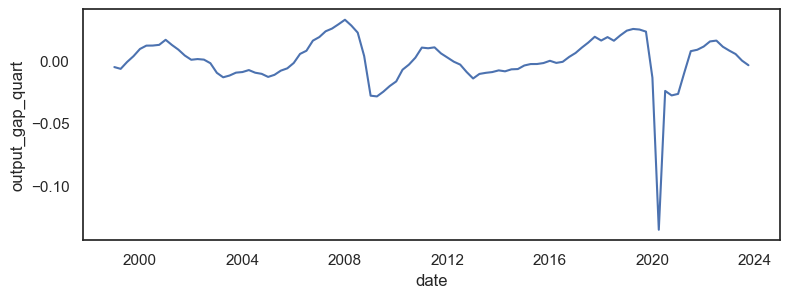

In [23]:
sns.lineplot(data=GDP["output_gap_quart"].tail(100));

## 2.4 Importing the Harmonised Index Consumer Prices (HICP) <a id="section_2_4"></a>

I download the Harmonised Index Consumer Prices (HICP) from FRED repository:  https://fred.stlouisfed.org/series/CP0000EZ19M086NEST

In [24]:
HICP = pd.read_csv("HICP_eurozona.csv")
HICP.rename(columns = {"DATE":"date" , "CP0000EZ19M086NEST":"HICP"}, inplace= True)
HICP.rename(columns = {"DATE":"date" , "HICP":"HICP"}, inplace= True)
HICP["date"] = pd.to_datetime(HICP["date"])

# I use the log transformation to obtain inflation:
HICP["Inflation"] = HICP["HICP"].pct_change(12)

# For merging purposes I extract the month-year values.
HICP["M-Y"] = HICP["date"].apply(lambda x: x.strftime('%B-%Y'))

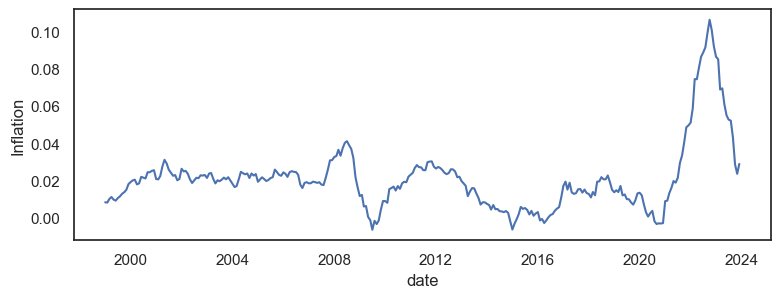

In [25]:
sns.lineplot(data=HICP.tail(300), x= HICP["date"].tail(300), y = HICP["Inflation"].tail(300) );

# 3. Cleaning ECB communications and matching meetings with rate changes<a id="chapter3"></a>

## 3.1 Cleaning the text 

I extract the words that do not provide value for the analysis

In [26]:
junk_strings = ['Click here for the transcript of questions and answers',
               'Jump to the transcript of the questions and answers',
                'With the transcript of the questions and answers',
                'With a transcript of the questions and answers']
junk_strings = [x.strip().lower() for x in junk_strings]

In [27]:
def clean_text(row):
    text = row.text
    date = row.date
    location = '' if pd.isna(row.location) else row.location
    lines = text.split('\n')

    result = []

    for line in lines:
        if date in line.strip() and location in line.strip():
            continue
        elif re.sub('[^\s\d\w]', '', line.strip().lower()) in junk_strings:
            continue
        result.append(line)
    return '\n'.join(result)

In [28]:
# Apply the clean_text function and tarnsform date format
df.rename(columns = {"Text": "text", "Date": "date", "Location": "location"} ,  inplace = True)
df['text'] = df.apply(clean_text, axis=1)
df['date'] = pd.to_datetime(df["date"])

C:\Users\camil\AppData\Local\Temp\ipykernel_46572\1986286755.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df["date"])


In [29]:
drop_rows = (df.loc[lambda x: x.text.str.lower().str.split('* * *', regex=False).str.len() == 1]
             .loc[lambda x: x.text.str.lower().str.split('question: ').str.len() == 1]).index

In [30]:
df.reset_index(drop=True, inplace=True)
df['intro_text'] = (df.text
                      .str.split('* * *', regex=False).str[0]
                      .str.split('Question: ').str[0]
                      .str.split('Q:').str[0])
df = df.set_index('date').sort_index()

## 3.2 Matching ECB meetings dates with MRO dates 

The MRO dataset reflect when the changes of the MRO take effect. The dates of the meetings and the change do not necesarily match, as the change can take effect days after it is announced. To make the match, I first analyze the time periods between the meetings and I observe that with the exception of 2 cases, meetings are spaced with at least 14 days.

In [31]:
date1 = pd.Series(df.index).head(-1).reset_index()
date2 = pd.Series(df.index).tail(-1).reset_index()

date2["date"].subtract(date1["date"]).nsmallest(10)

14    14 days
20    14 days
21    14 days
28    14 days
29    14 days
19    21 days
68    21 days
79    21 days
114   21 days
126   21 days
Name: date, dtype: timedelta64[ns]

Knowing that there are at least 14 days between meetings, I will assign to each meeting the rate corresponding to 14 days later. This way, there is time enough for potential rate changes to be enacted, this also allows to ensure that the rate does not correspond to a decision of the next meeting.

In [32]:
rate_date = pd.Series(df.index) + timedelta(days=14)
rate_date = rate_date.iloc[:-1]

In [33]:
dictio = {}

for x in rate_date:
    dictio[x] = mro.loc[x]

dictio2 = pd.DataFrame(dictio).transpose().reset_index()
dictio2["rate_date"] = pd.to_datetime(dictio2["index"])


mro = dictio2

For merging purposes, I add the "meeting_date" column to the mro data frame

In [34]:
mro["meeting_date"] = pd.to_datetime(rate_date - timedelta(days=14) )
mro["meeting_date"] == pd.to_datetime(df.iloc[:-1].index)

0      True
1      True
2      True
3      True
4      True
       ... 
252    True
253    True
254    True
255    True
256    True
Length: 257, dtype: bool

## 3.3 Table 1 

Now, I create the "Delta MRO" to obtain the change in the rate

In [35]:
mro["MRO"] = mro["MRO"].astype(float)

mro["Delta MRO"] = mro["MRO"].diff().fillna(0)

To be sure that the methodology used to match rates and meetings is correct, I check manually the rate change announced for every meeting

In [36]:
pd.options.display.max_rows = 260

In [37]:
mro

,index,MRO,year,rate_date,meeting_date,Delta MRO
0,1999-01-21,3.00,1999,1999-01-21,1999-01-07,0.00
1,1999-02-18,3.00,1999,1999-02-18,1999-02-04,0.00
2,1999-03-18,3.00,1999,1999-03-18,1999-03-04,0.00
3,1999-04-22,2.50,1999,1999-04-22,1999-04-08,-0.50
4,1999-05-20,2.50,1999,1999-05-20,1999-05-06,0.00
5,1999-06-16,2.50,1999,1999-06-16,1999-06-02,0.00
6,1999-07-29,2.50,1999,1999-07-29,1999-07-15,0.00
7,1999-09-23,2.50,1999,1999-09-23,1999-09-09,0.00
8,1999-10-21,2.50,1999,1999-10-21,1999-10-07,0.00
9,1999-11-18,3.00,1999,1999-11-18,1999-11-04,0.50


In [38]:
pd.options.display.max_rows = 20

This review allow us to identify the next mistakes:
* The change announced on 2000-03-30 was 0. The movement from 3.25 to 3.5 was announced on 2000-03-16 on a press release without press conference.
* The change announced on 2000-05-11 was 0.
* The change announced on 2000-09-14 was 0. The movement from 4.25 to 4.5 was announced on 2000-08-31 on a press release without press conference.
* The change announced on 2001-10-11 was 0. The movement from 4.25 to 3.75 was announced on 2001-09-17 on a press release without press conference.
* The change announced on 2008-10-02 was 0. The movement from 4.25 to 3.75 was announced on 2008-10-08 on a press release without press conference.

I proceed to fix them

In [39]:
mro.loc[14, "Delta MRO"] = 0
mro.loc[16, "Delta MRO"] = 0
mro.loc[19, "Delta MRO"] = 0
mro.loc[32, "Delta MRO"] = 0

Now, I present Table 1.

In [40]:


changes = {}
for x in mro["year"].unique():
    changes[x] = mro.groupby("year").get_group(x)["Delta MRO"].value_counts()

Table1 = pd.DataFrame(changes).transpose().fillna(0)
Table1["Total"] = Table1.sum(axis=1)

Table1.to_csv("Table1.csv")

Table1


Delta MRO,-0.75,-0.5,-0.25,-0.1,-0.1,-0.05,0.0,0.25,0.5,0.75,Total
1999,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,11.0
2000,0.0,0.0,0.0,0.0,0.0,0.0,10.0,2.0,1.0,0.0,13.0
2001,0.0,1.0,2.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,11.0
2002,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,11.0
2003,0.0,1.0,1.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
2019,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,8.0
2020,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,8.0
2021,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,8.0
2022,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,8.0


There is a difference with the original paper in the number of meetings registered for the year 2000. After a manual review, I confirmed that the ECB authorities held 13 press conferences during that year.

This is because I am counting the extraordinary ECB meetings held in Paris on October 19 2000 and in Madrid on March 30, 2000. I included these two press conferences as they included announcements regarding the monetary policy and the interest rates.

# 4. Communications analysis 

## 4.1 Measure of similarity between communications. 

To measure the similarity, I use the criteria from Tetlock (2011). For each communication, I obtain all the bigrams (understood as expressions of two words). Then I compare the consecutive texts with the measure:

$$Similarity_{i} = \frac{Bigrams_{i} \bigcap  Bigrams_{i-1}}{ Bigrams_{i} \bigcup Bigrams_{i-1}} $$

In [41]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [42]:
stemmer = PorterStemmer().stem
PUNCT_PATTERN = re.compile('[' + re.escape(punctuation.replace("'", '')  + '\n') + '\d' + ']')
stop_words = [stemmer(word_tokenize(x)[0]) for x in stopwords.words('english')]

def process_text(s):
    s = s.lower()
    s = re.sub(PUNCT_PATTERN, ' ', s)
    s = re.sub(' +', ' ', s)
    s = unidecode_expect_ascii(s)
    tokens = word_tokenize(s)
    stemmed_tokens = [stemmer(x) for x in tokens if x not in stop_words]
    bigrams = everygrams(stemmed_tokens, min_len=2, max_len=2)

    return set(bigrams)

In [43]:
df_bigrams = df.intro_text.apply(process_text)

In [44]:
def jaccard_similarity(a, b):
    union = a.union(b)
    intersection = a.intersection(b)

    return len(intersection) / len(union)

N = df.shape[0]
similarity_matrix = np.eye(N)
for i in range(N):
    for j in range(i):
        similarity_matrix[i, j] = jaccard_similarity(df_bigrams.iloc[i], df_bigrams.iloc[j])

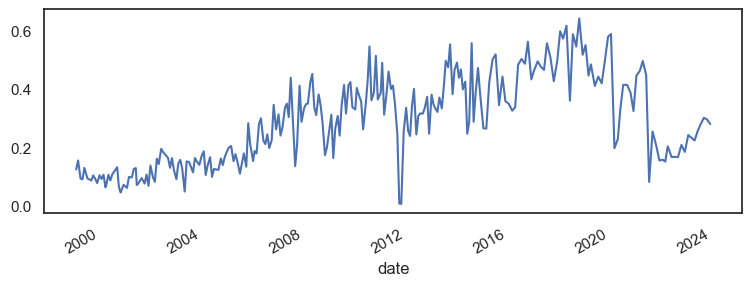

In [45]:
L1_similarity = pd.Series(np.diag(similarity_matrix, k=-1), index=df.index[1:], name='Similarity')
L1_similarity.plot();

In [46]:
L1_similarity = L1_similarity.astype("float")

## 4.2 Measure of pessimism/Sentiment analysis 

For the sentiment analysis, I download the Loughran-McDonald Master Dictionary from https://sraf.nd.edu/loughranmcdonald-master-dictionary/ and I upload it as a Data Frame.


To measure the sentiment, I classify all the relevant words in every communication as positive negative using the Loughran-McDonald Master Dictionary, then I obtain a sentiment measure for each communication using the formula:

$$Pessimism_{i} = \frac{NegativeWords_{i} - PositiveWords_{i}}{TotalWords_{i}} $$

In [47]:
word_dict = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2021.csv')

In [48]:
POS_WORDS = word_dict.set_index('Word')['Positive'].loc[lambda x: x != 0].index
NEG_WORDS = word_dict.set_index('Word')['Negative'].loc[lambda x: x != 0].index

In [49]:
df['Pessimism'] = classify_sentences(df.intro_text.tolist(), POS_WORDS, NEG_WORDS, stemmer=None, average_method='all')
df['Pessimism'] *= -1

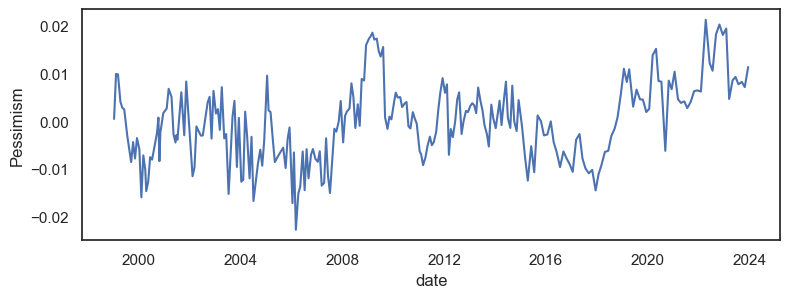

In [50]:
sns.lineplot(data=df['Pessimism']);

### 4.3 Create President dummy variables

In [51]:
# Fix inconsistencies in two cells
df.replace(to_replace= "Introductory statement Willem F. Duisenberg", value = "Willem F. Duisenberg", inplace= True)
df.loc["2003-09-04", "President"] = 'Willem F. Duisenberg'
df.replace(to_replace= "Willem F. Duisenberg", value = "1_Willem F. Duisenberg", inplace= True)

# Create the dummy variables
df = pd.get_dummies(df, prefix= "President", drop_first= True, columns = ["President"])

# Replace booleans for int
df = df.replace(to_replace= {True : 1, False: 0} )

C:\Users\camil\AppData\Local\Temp\ipykernel_46572\3315590294.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(to_replace= {True : 1, False: 0} )


Now,I create the interaction between the dummy variables and the pessimism measure

In [52]:
# Create dummy variables
dummies = ['President_Christine Lagarde','President_Jean Claude Trichet', 'President_Mario Draghi']
for dummy in dummies:
    df[("pessimis_" + dummy[10:] )]= df["Pessimism"] * df[dummy]

# 5.Data merging 

## 5.1 Merging 

In [53]:
df2 = df.merge(mro, how="left",left_index= True, right_on = "meeting_date")
df2.set_index("meeting_date", inplace = True)

In [54]:
df3 = df2.merge(stock_index, how = "left", left_index= True, right_index = True )

To merge with the GDP data set I extract the quarters

In [55]:
GDP.reset_index(inplace = True)
GDP_quarter = pd.DataFrame(GDP["date"].dt.to_period('Q'))

GDP_quarter.rename(columns ={"date" : "quarter"}, inplace=True)

GDP = GDP.merge(GDP_quarter, how="left",right_index=True, left_index=True)

In [56]:
df3.reset_index(inplace= True)

df3["quarter"] = pd.Series(df3["meeting_date"]).dt.to_period('Q')

In [57]:
df4 = df3.merge(GDP, how = "left", left_on= "quarter",  right_on="quarter")
df4.reset_index(inplace= True)

The HICP is a monthly variable. For merging purposes, I extract the month and year from the meeting_date column of df4

In [58]:
df4["M-Y"] = df4["meeting_date"].apply(lambda x: x.strftime('%B-%Y'))

# Drop unnecesary columns
df4 = df4.drop(columns = ["Unnamed: 0_x","level_0" ])
HICP = HICP.drop(columns = ["Unnamed: 0"])

In [59]:
df5 = df4.merge(HICP, how= "left", left_on= "M-Y", right_on= "M-Y" )
df5.set_index("meeting_date", inplace= True)

df5.drop(['index', 'Unnamed: 0', 'date_x', 'date_y'], axis=1, inplace = True)

# drop NaN
df6 = df5.dropna(subset=['output_gap_quart'])

In [60]:
df7 = df6.merge(L1_similarity, how= "left", left_index=True, right_index=True)

df7.dropna(subset=["Similarity"], inplace = True)

## 5.2.Creating Time and Time count variables 


Now I create the Time variable which counts the number of days passed since the first announcement, and add the time(count variable)

In [61]:
df7 = df7.reset_index().reset_index().rename(columns = {"index": "Time count"})

df7["Time"] = df7["meeting_date"] - pd.to_datetime("1999-02-04")
df7["Time"] = (df7["Time"].dt.total_seconds()/86400)


df7.set_index("meeting_date", inplace = True)

## 5.3. Appliying the log transformation to similarity 

For the regression models I apply the log transformation to similarity

In [62]:
df7["log_Similarity"] = np.log(df7["Similarity"])

Now, I create the interaction of pessimisism and similarity

In [63]:
df7["Pessimism x similarity"] = df7["Pessimism"] * df7["Similarity"]
df7["Pessimism x log_similarity"] = df7["Pessimism"] * df7["log_Similarity"]

Finally, I drop the last observation due to the NaN values

In [64]:
df7 = df7.head(256)

# 6. Table 2: Descriptive statistics 

In [65]:
Table2 = df7[["cum_ab_returns", 'AV_cum_ab_returns', 'Pessimism',  "Similarity",
     'output_gap_quart', 'Inflation', 'Delta MRO']].describe().transpose()

Table2.to_csv("Table2.csv")

Table2

,count,mean,std,min,25%,50%,75%,max
cum_ab_returns,256.0,0.000177,0.045911,-0.338674,-0.021272,0.002994,0.026169,0.124329
AV_cum_ab_returns,256.0,0.031685,0.033166,0.000102,0.012648,0.024065,0.041584,0.338674
Pessimism,256.0,-0.000172,0.008032,-0.022757,-0.006002,-0.000248,0.004677,0.021341
Similarity,256.0,0.284253,0.148280,0.006322,0.154538,0.281361,0.400840,0.641536
output_gap_quart,256.0,0.000271,0.018396,-0.135591,-0.009249,-0.000099,0.011056,0.032630
Inflation,256.0,0.020801,0.016661,-0.006199,0.012397,0.020023,0.024639,0.106206
Delta MRO,256.0,0.004883,0.164393,-0.750000,0.000000,0.000000,0.000000,0.750000


# 7. Estimations 

## 7.1 Table 3 

### Table 3 equation 1

In [66]:
x = df7[['output_gap_quart', "Inflation", "Delta MRO"]]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "1"})
tab_5_eq_3 = eq1.copy()

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     8.119
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           3.50e-05
Time:                        09:51:22   Log-Likelihood:                -253.68
No. Observations:                 256   AIC:                             515.4
Df Residuals:                     252   BIC:                             529.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1466      0.073  

### Table 3 equation 2

In [67]:
x = df7[['Time']]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq2 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "2"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     137.8
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           1.05e-25
Time:                        09:51:22   Log-Likelihood:                -210.02
No. Observations:                 256   AIC:                             424.0
Df Residuals:                     254   BIC:                             431.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1095      0.067    -31.627      0.0

### Table 3 equation 3

In [68]:
x = df7[["Time",'output_gap_quart', "Inflation", "Delta MRO"]]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()


eq3 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "3"})
tab_5_eq3 = eq3.copy()

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg3.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     61.15
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           5.21e-36
Time:                        09:51:22   Log-Likelihood:                -178.40
No. Observations:                 256   AIC:                             366.8
Df Residuals:                     251   BIC:                             384.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8147      0.072  

### Table 3 equation 4

In [69]:
x = df7[["Time count",'output_gap_quart', "Inflation", "Delta MRO"]]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq4 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "4"})
tab_5_eq_4 =eq4.copy()

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg4.csv', 'w') as f:
    f.write(csv_data)


                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     65.11
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           1.04e-37
Time:                        09:51:22   Log-Likelihood:                -174.38
No. Observations:                 256   AIC:                             358.8
Df Residuals:                     251   BIC:                             376.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8776      0.073  

### Table 3
I merge the results of each equation to obtain the Table 3:

In [70]:
merge1 = eq1.merge(eq2, how ="outer", left_index=True, right_index= True)
merge2 = merge1.merge(eq3, how ="outer", left_index=True, right_index= True)
merge3 = merge2.merge(eq4, how ="outer", left_index=True, right_index= True).sort_index(ascending = True)

Table3 = merge3
Table3.to_csv("2Table3.csv")
Table3

,1,2,3,4
Delta MRO,0.709820,NaN,0.261886,0.272154
Inflation,-14.280953,NaN,-17.761299,-16.660871
R2,0.088133,0.351689,0.493561,0.509219
Time,NaN,0.000160,0.000178,NaN
Time count,NaN,NaN,NaN,0.006132
const,-1.146637,-2.109483,-1.814667,-1.877570
output_gap_quart,3.327109,NaN,6.400605,6.176874


## 7.2 Table 4 

### Table 4 equation 1

In [71]:
x = df7[["Pessimism"]]
y = df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "1"})
tab_6_eq1 = eq1.copy()

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2_1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.430
Date:                Tue, 12 Nov 2024   Prob (F-statistic):            0.00686
Time:                        09:51:22   Log-Likelihood:                 512.94
No. Observations:                 256   AIC:                            -1022.
Df Residuals:                     254   BIC:                            -1015.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0318      0.002     15.532      0.0

### Table 4 equation 2

In [72]:
x = df7[["output_gap_quart", "Inflation", "Delta MRO"]]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq2 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "2"})
tab_6_eq2 = eq2.copy()

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2_2.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.505
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0597
Time:                        09:51:22   Log-Likelihood:                 513.01
No. Observations:                 256   AIC:                            -1018.
Df Residuals:                     252   BIC:                            -1004.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0283      0.004  

### Table 4 equation 3

In [73]:
x = df7[["Pessimism x log_similarity"]]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq3 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "3"})
tab_6_eq3 =eq3.copy()

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2_3.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     6.301
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0127
Time:                        09:51:22   Log-Likelihood:                 512.39
No. Observations:                 256   AIC:                            -1021.
Df Residuals:                     254   BIC:                            -1014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Table 4 equation 4

In [74]:
x = df7[["Pessimism x log_similarity", "output_gap_quart", "Inflation", "Delta MRO"]]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq4 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "4"})
tab_6_eq4 = eq4.copy()

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2_4.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.704
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0310
Time:                        09:51:22   Log-Likelihood:                 514.65
No. Observations:                 256   AIC:                            -1019.
Df Residuals:                     251   BIC:                            -1002.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Table 4 equation 5
Equation 5 is ommitted as the MRO surprise variable is built using Bloomberg consensus and I do not have access to it.

### Table 4

I merge the results of each equation to obtain the Table 4:

In [75]:
merge1 = eq1.merge(eq2, how ="outer", left_index=True, right_index= True)
merge2 = merge1.merge(eq3, how ="outer", left_index=True, right_index= True)
merge3 = merge2.merge(eq4, how ="outer", left_index=True, right_index= True).sort_index(ascending = True)


Table4 = merge3
Table4.to_csv("2Table4.csv")
Table4

,1,2,3,4
Delta MRO,NaN,-0.032591,NaN,-0.025374
Inflation,NaN,0.170673,NaN,0.047082
Pessimism,0.696154,NaN,NaN,NaN
Pessimism x log_similarity,NaN,NaN,-0.405044,-0.326287
R2,0.028422,0.028958,0.024208,0.041308
const,0.031805,0.028339,0.031887,0.031019
output_gap_quart,NaN,-0.164827,NaN,-0.096266


# 8. Extension

### Table 5 equation 3.1

In [76]:
x = df7[["Time",'output_gap_quart', "Inflation", "Delta MRO",
        'President_Christine Lagarde','President_Jean Claude Trichet', 'President_Mario Draghi']]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

tab_5_eq_3_1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "3_1"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('5_reg3_1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     51.49
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           6.79e-45
Time:                        09:51:22   Log-Likelihood:                -150.61
No. Observations:                 256   AIC:                             317.2
Df Residuals:                     248   BIC:                             345.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Table 5 equation 4.1

In [77]:
x = df7[["Time count",'output_gap_quart', "Inflation", "Delta MRO",
         'President_Christine Lagarde','President_Jean Claude Trichet', 'President_Mario Draghi']]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

tab_5_eq_4_1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "4_1"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('5_reg4_1.csv', 'w') as f:
    f.write(csv_data)


                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     52.08
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           2.98e-45
Time:                        09:51:22   Log-Likelihood:                -149.75
No. Observations:                 256   AIC:                             315.5
Df Residuals:                     248   BIC:                             343.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Table 5

In [78]:
merge1 = tab_5_eq3.merge(tab_5_eq_4, how ="outer", left_index=True, right_index= True)
merge2 = merge1.merge(tab_5_eq_3_1, how ="outer", left_index=True, right_index= True)
merge3 = merge2.merge(tab_5_eq_4_1, how ="outer", left_index=True, right_index= True).sort_index(ascending = True)

Table5 = merge3
Table5.to_csv("Table5.csv")
Table5

,3,4,3_1,4_1
Delta MRO,0.261886,0.272154,0.348663,0.360734
Inflation,-17.761299,-16.660871,-12.170009,-11.925011
President_Christine Lagarde,NaN,NaN,-0.730527,-0.701988
President_Jean Claude Trichet,NaN,NaN,0.287278,0.243758
President_Mario Draghi,NaN,NaN,-0.071810,-0.156397
R2,0.493561,0.509219,0.592416,0.595149
Time,0.000178,NaN,0.000251,NaN
Time count,NaN,0.006132,NaN,0.008666
const,-1.814667,-1.877570,-2.227331,-2.252412
output_gap_quart,6.400605,6.176874,2.256748,2.629686


### Table 6 equation 1.1

In [79]:
x = df7[["Pessimism", 'pessimis_Christine Lagarde', 'pessimis_Jean Claude Trichet','pessimis_Mario Draghi']]
y = df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

tab_6_eq1_1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "1_1"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('6reg1_1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.185
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0712
Time:                        09:51:22   Log-Likelihood:                 513.63
No. Observations:                 256   AIC:                            -1017.
Df Residuals:                     251   BIC:                            -999.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Table 6 equation 2.1

In [80]:
x = df7[["output_gap_quart", "Inflation", "Delta MRO",
        'pessimis_Christine Lagarde', 'pessimis_Jean Claude Trichet','pessimis_Mario Draghi']]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

tab_6_eq2_1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "2_1"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('6reg2_1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.384
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0294
Time:                        09:51:22   Log-Likelihood:                 516.40
No. Observations:                 256   AIC:                            -1019.
Df Residuals:                     249   BIC:                            -994.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Table 6 equation 3.1

In [81]:
x = df7[["Pessimism x log_similarity", 'pessimis_Christine Lagarde', 'pessimis_Jean Claude Trichet','pessimis_Mario Draghi']]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

tab_6_eq3_1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "3_1"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('6reg3_1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.174
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0725
Time:                        09:51:22   Log-Likelihood:                 513.61
No. Observations:                 256   AIC:                            -1017.
Df Residuals:                     251   BIC:                            -999.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Table 6 equation 4.1

In [82]:
x = df7[["Pessimism x log_similarity", "output_gap_quart", "Inflation", "Delta MRO",
        'pessimis_Christine Lagarde', 'pessimis_Jean Claude Trichet','pessimis_Mario Draghi']]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

tab_6_eq4_1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "4_1"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('6reg4_1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.036
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0512
Time:                        09:51:22   Log-Likelihood:                 516.40
No. Observations:                 256   AIC:                            -1017.
Df Residuals:                     248   BIC:                            -988.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Table 6

In [83]:
merge1 = tab_6_eq2.merge(tab_6_eq4, how ="outer", left_index=True, right_index= True)
merge2 = merge1.merge(tab_6_eq2_1, how ="outer", left_index=True, right_index= True)
merge3 = merge2.merge(tab_6_eq4_1, how ="outer", left_index=True, right_index= True).sort_index(ascending = True)


Table6 = merge3
Table6.to_csv("Table6.csv")
Table6

,2,4,2_1,4_1
Delta MRO,-0.032591,-0.025374,-0.031340,-0.031669
Inflation,0.170673,0.047082,-0.112506,-0.111779
Pessimism x log_similarity,NaN,-0.326287,NaN,0.025593
R2,0.028958,0.041308,0.054316,0.054349
const,0.028339,0.031019,0.032826,0.032775
output_gap_quart,-0.164827,-0.096266,0.010195,0.010796
pessimis_Christine Lagarde,NaN,NaN,1.612250,1.657867
pessimis_Jean Claude Trichet,NaN,NaN,0.629483,0.663409
pessimis_Mario Draghi,NaN,NaN,0.235899,0.256402
